In [1]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
# Read pickle file with topics and augmented text
df4 = pd.read_pickle("data/allData.pkl")

In [4]:
corpus = df4['TEXT'].values

count_vect = CountVectorizer(stop_words=stopwords.words('english'), lowercase=True)
x_counts = count_vect.fit_transform(corpus)
x_counts.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [5]:
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)

In [6]:
dimension = 8
sample_size = 100000

np.random.seed(232323)
sample = x_tfidf[np.random.choice(x_tfidf.shape[0], sample_size, replace=False), :]

lda = LDA(n_components = dimension, random_state=9999)
lda_array = lda.fit_transform(sample)

In [7]:
topic_vec = lda.transform(x_tfidf)

df4['TOPIC'] = np.argmax(topic_vec, axis = 1)

In [8]:
df4.to_pickle("data/allData.pkl")

In [9]:
pyLDAvis.enable_notebook()

In [10]:
pyLDAvis.sklearn.prepare(lda, x_tfidf, count_vect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.095938 -0.207287       1        1  18.845987
6      0.158881  0.012096       2        1  16.678621
7      0.123402 -0.049855       3        1  15.935660
5     -0.127272 -0.027651       4        1  13.627728
0      0.152434  0.157355       5        1  12.716643
3     -0.177803 -0.100295       6        1  10.583708
4     -0.055714  0.134977       7        1   7.104289
1     -0.169865  0.080659       8        1   4.507364, topic_info=          Term          Freq         Total Category  logprob  loglift
77371     time  48846.000000  48846.000000  Default  30.0000  30.0000
626     active  47447.000000  47447.000000  Default  29.0000  29.0000
27151   flight  49322.000000  49322.000000  Default  28.0000  28.0000
27619     foot  64463.000000  64463.000000  Default  27.0000  27.0000
21776  eastern  52914.000000  52914.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
58451     path   1232.141880   9240.027882   Topic8  -5.3159   1.0847
70653  service    954.876906  44986.973985   Topic8  -5.5709  -0.7531
21316      due    699.557501   9459.498055   Topic8  -5.8820   0.4951
44296  lighted    595.816241   5799.204012   Topic8  -6.0425   0.8239
45159  locator    618.024569  16290.567268   Topic8  -6.0059  -0.1724

[524 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
168        1  0.004897  abel
168        2  0.004897  abel
168        3  0.004897  abel
168        4  0.004897  abel
168        5  0.972135  abel
...      ...       ...   ...
87414      4  0.005667   zmp
87414      5  0.005667   zmp
87414      6  0.966240   zmp
87414      7  0.005667   zmp
87414      8  0.005667   zmp

[3384 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 8, 6, 1, 4, 5, 2])

In [11]:
#pyLDAvis.sklearn.prepare(lda, x_tfidf, count_vect, mds='mmds')

In [12]:
#pyLDAvis.sklearn.prepare(lda, x_tfidf, count_vect, mds='tsne')

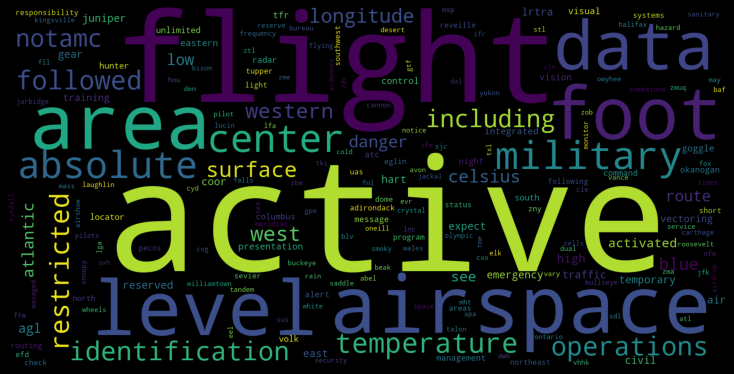

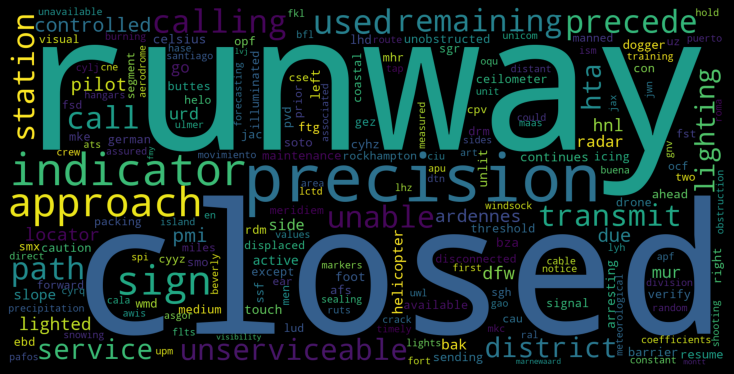

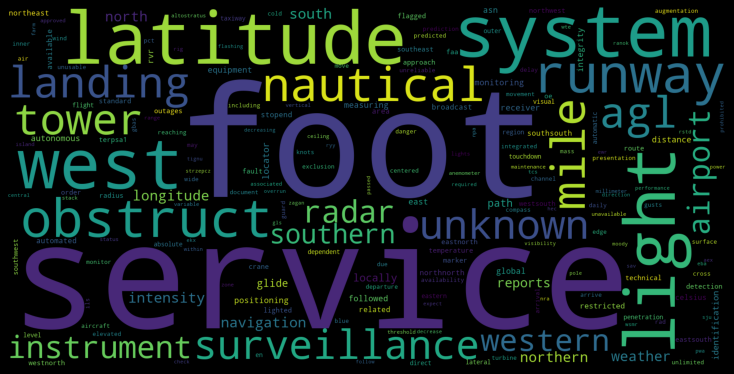

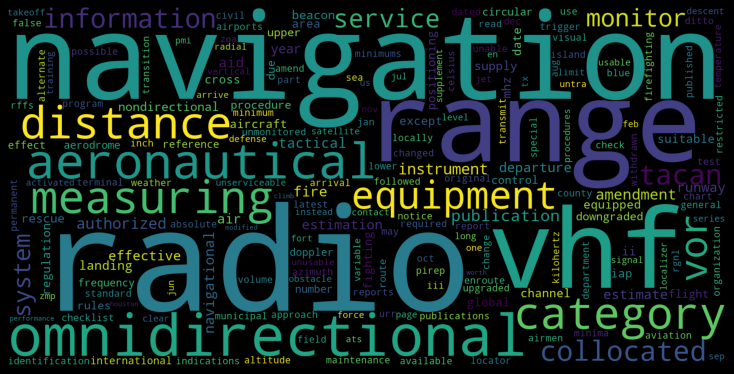

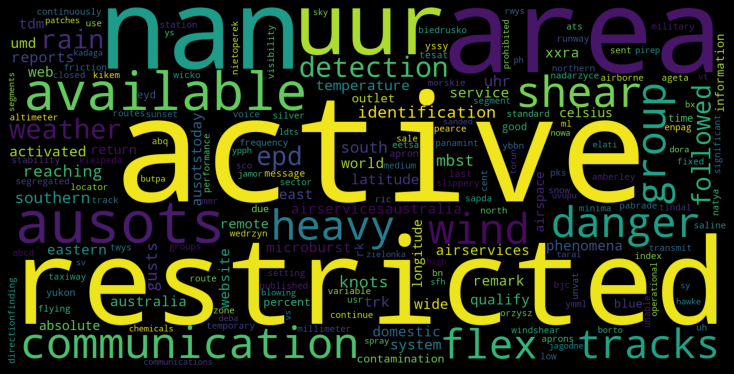

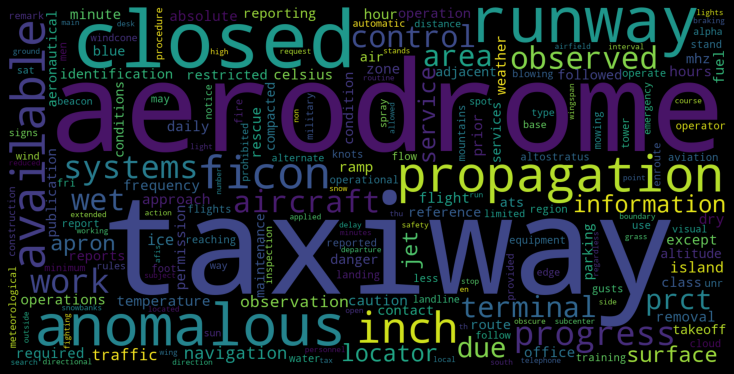

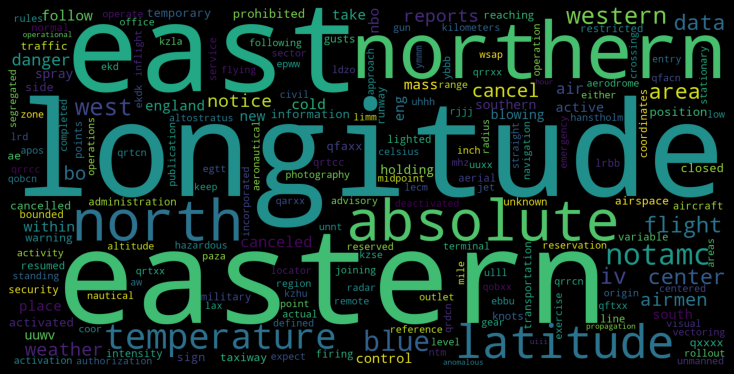

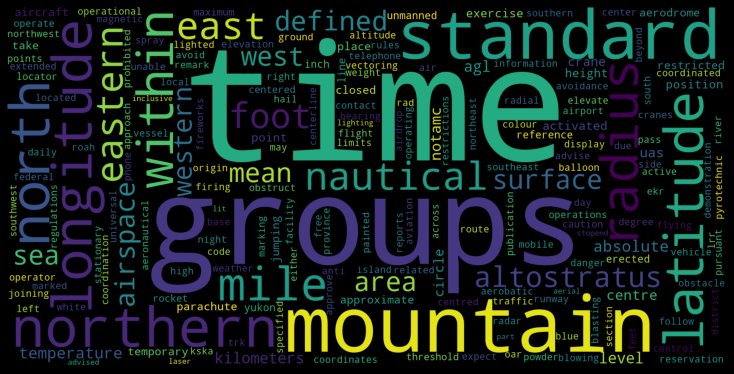

In [14]:
features = count_vect.get_feature_names_out()

for dim in range(dimension):
    output = {}
    for idx, i in enumerate(lda.components_[dim]):
        output[features[idx]] = i

    wordcloud = WordCloud(width=1600, height=800).fit_words(output)

    plt.figure(figsize=(15,5), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()